## Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

In [2]:
# data import
df_s = pd.read_csv('df_s_concave.csv')
df_s_true = pd.read_csv('df_s_true_concave.csv')
df_t = pd.read_csv('df_t_concave.csv')
df_t_true = pd.read_csv('df_t_true_concave.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_concave.csv')
for i in range(10):
    exec(f"df_t{i} = pd.read_csv('df_t{i}_concave.csv')")

In [3]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)
for i in range(10):
    exec(f"x_t{i} = torch.tensor(df_t{i}['X']).reshape(-1,1).type(torch.float32)")
    exec(f"y_t{i} = copy.deepcopy(y_s)")
x_t10 = copy.deepcopy(x_s)
y_t10 = copy.deepcopy(y_s)

## MAML

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 256)
        self.relu = nn.ReLU()
        self.h2 = nn.Linear(256, 256)
        self.h3 = nn.Linear(256, 256)
        self.reg = nn.Linear(256, 1)
        self.drop1 = nn.Dropout()
        self.drop2 = nn.Dropout()
        
    def forward(self, x):
        x = self.h1(x)
        x = self.relu(x)
        x = self.h2(x)
        x = self.relu(x)
        x = self.h3(x)
        x = self.relu(x)
        x = self.reg(x)

        return x

### Meta-Learning

In [5]:
parent_model = MLP()
optimizer = optim.Adam(parent_model.parameters(), lr=0.001)
domain_num = 10 + 1
batch_domain = 3
batch_num = 20

for outer_epoch in range(10000):
    parent_model.eval()
    
    batch_domain_list = random.sample(range(domain_num), batch_domain)
    batch_data_list = random.sample(range(len(x_t0)), batch_num*2)
    batch_train_data_list = batch_data_list[:10]
    batch_val_data_list = batch_data_list[10:]
    for batch_domain_idx in batch_domain_list:
        exec(f"child_model{batch_domain_idx} = copy.deepcopy(parent_model)")
        exec(f"optimizer{batch_domain_idx} = optim.Adam(child_model{batch_domain_idx}.parameters(), lr = 0.001)")
        exec(f"child_model{batch_domain_idx}.train()")
        exec(f"optimizer{batch_domain_idx}.zero_grad()")
        for inner_epoch in range(10):
            exec(f"temp_loss = torch.nn.functional.mse_loss(child_model{batch_domain_idx}(x_t{batch_domain_idx}[batch_train_data_list]), x_s[batch_train_data_list])")
            temp_loss.backward()
            exec(f"optimizer{batch_domain_idx}.step()")
    
    parent_model.train()
    optimizer.zero_grad()
    loss = 0
    for batch_domain_idx in batch_domain_list:
        exec(f"loss += torch.nn.functional.mse_loss(child_model{batch_domain_idx}(x_t{batch_domain_idx}[batch_val_data_list]), x_s[batch_val_data_list])")
    loss /= batch_domain
    loss.backward()
    optimizer.step()

    if outer_epoch % 100 == 99:
        print(f"epoch : {outer_epoch}, train loss : {loss.detach().item()}")

epoch : 99, train loss : 254.0540771484375
epoch : 199, train loss : 457.8583984375
epoch : 299, train loss : 30414.7734375
epoch : 399, train loss : 296.5974426269531
epoch : 499, train loss : 28.04401206970215
epoch : 599, train loss : 47.30873107910156
epoch : 699, train loss : 101.81009674072266
epoch : 799, train loss : 2420.261474609375
epoch : 899, train loss : 1379.21630859375
epoch : 999, train loss : 92.41283416748047
epoch : 1099, train loss : 118290.2109375
epoch : 1199, train loss : 24.81327247619629
epoch : 1299, train loss : 63.48173522949219
epoch : 1399, train loss : 52.12953567504883
epoch : 1499, train loss : 293.2540588378906
epoch : 1599, train loss : 42.17642593383789
epoch : 1699, train loss : 724.75048828125
epoch : 1799, train loss : 884.090576171875
epoch : 1899, train loss : 59.63679504394531
epoch : 1999, train loss : 108.02447509765625
epoch : 2099, train loss : 15.50940990447998
epoch : 2199, train loss : 111.54515838623047
epoch : 2299, train loss : 35.35

### Meta-Inference

In [6]:
target_model = copy.deepcopy(parent_model)
target_model.train()
target_optimizer = optim.Adam(target_model.parameters(), lr=0.001)
train_loss_list = []
test_loss_list = []
true_test_loss_list = []
model_list = []
for i in range(2000):
    model_list.append(copy.deepcopy(target_model))
    target_model.eval()
    target_model(x_t)
    test_loss_list.append(torch.nn.functional.mse_loss(target_model(x_t), y_t).detach().item())
    true_test_loss_list.append(torch.nn.functional.mse_loss(target_model(x_t), y_t_true).detach().item())

    target_model.train()
    target_optimizer.zero_grad()
    train_loss = torch.nn.functional.mse_loss(target_model(x_t_labeled), y_t_labeled)
    train_loss.backward()
    target_optimizer.step()
    train_loss_list.append(train_loss.detach().item())

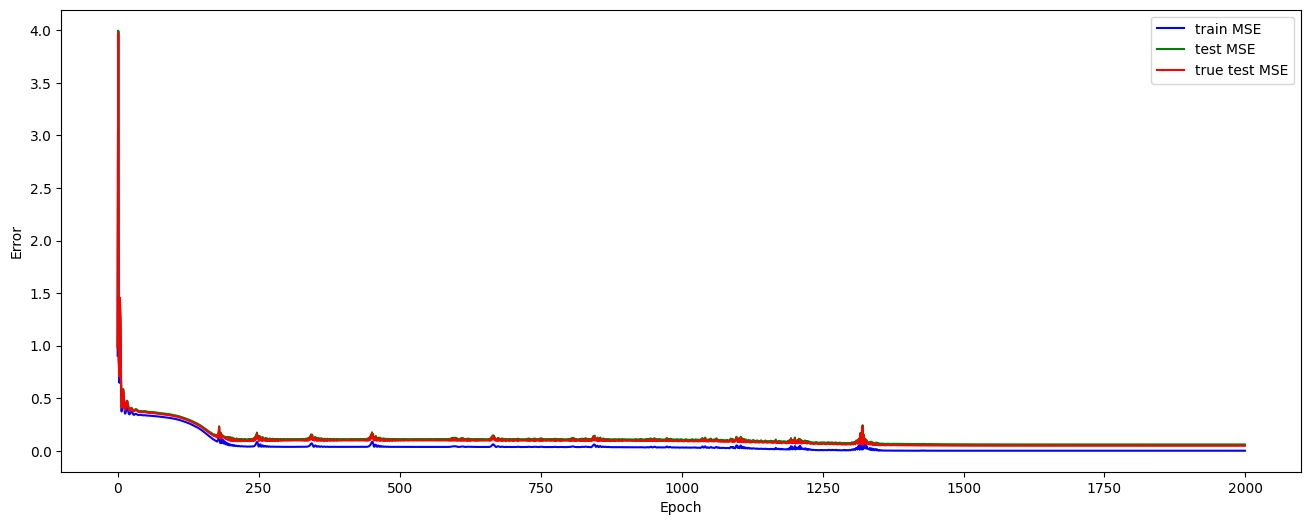

In [7]:
plt.figure(figsize=(16,6))
plt.plot(range(len(train_loss_list)), train_loss_list, c='blue', label='train MSE', zorder=1)
plt.plot(range(len(train_loss_list)), test_loss_list, c='green', label='test MSE', zorder=2)
plt.plot(range(len(train_loss_list)), true_test_loss_list, c='red', label='true test MSE', zorder=3)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

test mse : 0.059725094586610794, denoised test mse : 0.04705479368567467


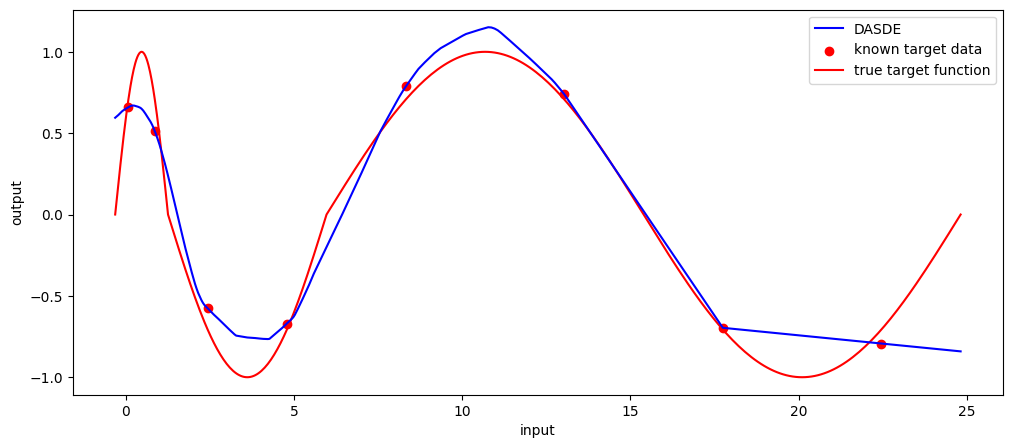

In [8]:
plt.figure(figsize=(12,5))
plt.plot(x_t, target_model(x_t).detach().numpy(), c='blue', label='DASDE', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
print(f"test mse : {test_loss_list[-1]}, denoised test mse : {true_test_loss_list[-1]}")